In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy import distinct
from sqlalchemy import desc

In [6]:
engine = create_engine("sqlite:////Users/moradocuevas/Desktop/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
STation = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
conn = engine.connect()

In [12]:
measure_data = pd.read_sql("SELECT * FROM measurement", conn)
measure_data = meshure_data.sort_values(['date'], ascending=False)
measure_data.head(10)


,id,station,date,prcp,tobs
19549,19550,USC00516128,2017-08-23,0.45,76.0
12186,12187,USC00519523,2017-08-23,0.08,82.0
2723,2724,USC00519397,2017-08-23,0.00,81.0
7634,7635,USC00514830,2017-08-23,0.00,82.0
12185,12186,USC00519523,2017-08-22,0.00,82.0
2722,2723,USC00519397,2017-08-22,0.00,82.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
7633,7634,USC00514830,2017-08-21,0.02,79.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
12184,12185,USC00519523,2017-08-21,NaN,82.0


In [13]:
station_data = pd.read_sql("SELECT * FROM station", conn)
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

query_prec = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > query_date).\
                order_by(Measurement.date).all()


In [15]:
prec_date_df = pd.DataFrame(query_prec)
prec_date_df = prec_date_df.fillna(0)
prec_date_df = prec_date_df.set_index('date')
prec_date_df = prec_date_df.sort_values(['date'], ascending=False)
prec_date_df.head()

,prcp
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.50


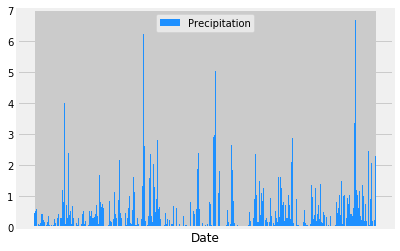

In [16]:
x_axis = prec_date_df.index

# Plotting bars
prec_bars = plt.bar(x_axis, prec_date_df['prcp'], width=1, 
                    color='dodgerblue', alpha=1, align="center",
                    label='Precipitation')

plt.xlabel("Date")

plt.legend(handles=[prec_bars], loc="upper center")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.grid(True)
plt.show()

In [17]:
# Use Pandas to print the summary statistics for the precipitation data.

prec_date_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2223 entries, 2017-08-23 to 2016-08-24
Data columns (total 1 columns):
prcp    2223 non-null float64
dtypes: float64(1)
memory usage: 34.7+ KB


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(func.count(Measurement.date).label('count'), 
                       Measurement.station).\
                        group_by(Measurement.station).\
                        order_by(desc('count')).all()

active


[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [20]:
# Which station has the highest number of observations?
active[0]

(2772, 'USC00519281')

In [21]:
session.query(Station.name).filter_by(station="USC00519281").all()


[('WAIHEE 837.5, HI US')]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_t = session.query(func.min(Measurement.tobs)).\
            filter_by(station='USC00519281').all()

avg_t = session.query(func.avg(Measurement.tobs)).\
            filter_by(station='USC00519281').all()

max_t = session.query(func.max(Measurement.tobs)).\
            filter_by(station='USC00519281').all()


print(f'LOWEST  Temp. Rec. in {session.query(Station.name).filter_by(station="USC00519281").all()} : {(min_t)}')
print(f'----------------------------------------------------------------------')
print(f'AVERAGE Temp. Rec. in {session.query(Station.name).filter_by(station="USC00519281").all()} : {(avg_t)}')
print(f'----------------------------------------------------------------------')
print(f'HIGHEST Temp. Rec. in {session.query(Station.name).filter_by(station="USC00519281").all()} : {(max_t)}')



LOWEST  Temp. Rec. in [('WAIHEE 837.5, HI US',)] : [(54.0,)]
----------------------------------------------------------------------
AVERAGE Temp. Rec. in [('WAIHEE 837.5, HI US',)] : [(71.66378066378067,)]
----------------------------------------------------------------------
HIGHEST Temp. Rec. in [('WAIHEE 837.5, HI US',)] : [(85.0,)]


In [23]:
# Choose the station with the highest number of temperature observations.
high_tobs = session.query(func.count(Measurement.tobs).label('count'), 
                         Measurement.station).\
                         group_by(Measurement.station).\
                         order_by(desc('count')).all()
high_tobs[0]


(2772, 'USC00519281')

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# tobs vs count(tobs)

tobs12 = session.query(Measurement.date, Measurement.tobs, Measurement.station).\
                filter(Measurement.date > query_date).\
                order_by(Measurement.date).all()

tobs12_df = pd.DataFrame(tobs12)

tobs_plot = tobs12_df.loc[(tobs12_df['station']=='USC00519281')]

tobs_plot = tobs_plot.reset_index()

tobs_plot.head()


,index,date,tobs,station
0,5,2016-08-24,77.0,USC00519281
1,12,2016-08-25,80.0,USC00519281
2,19,2016-08-26,80.0,USC00519281
3,24,2016-08-27,75.0,USC00519281
4,30,2016-08-28,73.0,USC00519281


In [25]:
# Finding the Lowest Temperature value for the last 12 months
tobs_plot.tobs.min()

59.0

In [26]:
# Finding the Highest Temperature value for the last 12 months
tobs_plot.tobs.max()

83.0

In [27]:
# Setting bins = 12

bins = [59, 61, 63, 65, 67, 69,
        71, 73, 75, 77, 79, 81, 83]

group_names = ["59-61", "61-63", "63-65", "65-67", 
               "67-69", "69-71", "71-73", "73-75",
               "75-77", "77-79", "79-81", "81-83"]

tobs_plot["Frecuency"] = pd.cut(tobs_plot["tobs"], bins, labels = group_names)
tobs_plot = tobs_plot.groupby(['Frecuency'])
tobs_plot = tobs_plot[['date']].count()

tobs_plot


,date
Frecuency,
59-61,3
61-63,10
63-65,10
65-67,20
67-69,31
69-71,40
71-73,40
73-75,72
75-77,63


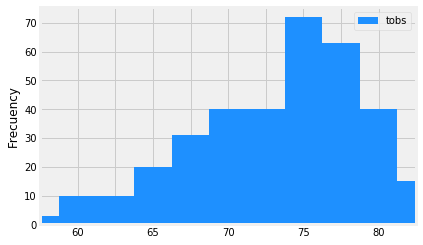

In [28]:
# Plotting bars
frec_tobs = plt.bar(tobs_plot.index, tobs_plot.date, width=1, 
                    color='dodgerblue', alpha=1, align="center",
                    label='tobs')

plt.legend(handles=[frec_tobs], loc="best")

# Ticks

plt.xticks(np.arange(10), ('', '60', '', '65', '',
                           '70', '', '75', '', '80'))

plt.ylabel("Frecuency")

plt.xlim(0,10)


plt.show(frec_tobs)


In [29]:
# Use FLASK to create your routes.
from flask import Flask, jsonify

In [30]:
# Flask Setup
app = Flask(__name__)

In [31]:
# Flask Routes

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/measurement<br/>"
        f"/api/v1.0/station"
    )

@app.route("/api/v1.0/measurement")
def measurement():
    """Return a list of all measurements"""
    
    results = session.query(Measurement).all()

    return jsonify(results)


@app.route("/api/v1.0/station")
def station():
    """Return a list of all stations"""
    
    results = session.query(Station).all()

    return jsonify(results)

In [32]:
# /api/v1.0/precipitation
# Convert the query results to a Dictionary using date as the key and prcp as the value.
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return a dictionary of all precipitations"""
    results = session.query(Station.date, Station.prcp).all()

    all_prcp = []
    
    for date, prcp in results:
        prcp_dict = {}
        prcp_dict['date'] = date
        prcp_dict['prcp'] = prcp
        all_prcp.append(prcp_dict)

    #Return the JSON representation of your dictionary.

    return jsonify(precipitation)





In [33]:
# /api/v1.0/stations
# Return a JSON list of stations from the dataset.

@app.route("/api/v1.0/stations")
def stations():
    """Return a list of all stations"""
    results = session.query(Station.name).all()

    return jsonify(results)



In [34]:
# /api/v1.0/tobs
# Query for the dates and temperature observations from a year from the last data point.

@app.route("/api/v1.0/tobs")
def tobs():
    # last year range time already calculated:
    # query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

    """Return a list of all temperature observations"""
    results = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > query_date).\
                order_by(desc(Measurement.date)).all()


# Return a JSON list of Temperature Observations (tobs) for the previous year.

    return jsonify(results)




In [35]:
# Return a JSON list of the minimum temperature, the average temperature,
# and the max temperature for a given start or start-end range.


# When given the start and the end date, calculate the TMIN, TAVG, 
# and TMAX for dates between the start and end date inclusive.

@app.route("/api/v1.0/<start>/<end>")
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX from start_date until end_date
    """
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    return jsonify(results)

# When given the start only, calculate TMIN, TAVG, and TMAX for all dates
# greater than and equal to the start date.

@app.route("/api/v1.0/<start>")
def calc_temp(start_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX from start_date until the last date registered
    """
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= func.max(Measurement.date)).all()
    
    return jsonify(results)

